In [25]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from src.features import utils, build_features_final
from src.models import predict_model
from src.train.train import train, evaluation, prediction_to_csv
from src.data.make_dataset import DatasetLoader
from src.visualization.visual import anomaly_plot
from src.config.config import seed_everything, cfg

warnings.filterwarnings(action='ignore')
seed_everything(cfg.SEED)

scaler = MinMaxScaler()

train_data = pd.read_csv(r'data\raw\train_data.csv')
# add_train = pd.read_csv(r'data/processed/robust.csv')
# train_data = pd.concat([train_data, add_train], axis=0)
# train_data = utils.outlier_z_score_filter_df(train_data)
train_data = build_features_final.create_derived_features(train_data)

test_data = pd.read_csv(r'data\raw\test_data.csv')
test_data = build_features_final.create_derived_features(test_data)

scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

scaled_train_data = pd.DataFrame(scaled_train_data, columns=train_data.columns)
scaled_test_data = pd.DataFrame(scaled_test_data, columns=train_data.columns)

grouped_train = scaled_train_data.groupby('type')

drop_feature = ['type', 'motor_hp', 'air_end_temp', 'motor_rpm', 'motor_temp', 'motor_vibe', 'motor_current',
                'air_inflow', "air_flow_pressure", "current_by_vibration", "airflow_per_rotation", "air_to_motor_ratio"]

anomaly = []
all_threshold = []
for group_name, group_data in grouped_train:
    test_group = scaled_test_data[scaled_test_data['type'] == group_name]
    train_group = group_data.drop(drop_feature, axis=1).values
    test_group = test_group.drop(drop_feature, axis=1).values

    n_features = train_group.shape[1]
    dataloader = DatasetLoader(train_group, test_group)
    train_loader, test_loader = dataloader.load
    model = predict_model.AutoEncoder(input_dim=n_features)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train(train_loader, model, criterion, optimizer)

    train_prediction, train_threshold = evaluation(train_loader, model)
    test_prediction, test_threshold = evaluation(
        test_loader, model, min(train_threshold))

    anomaly.append(test_prediction)
    all_threshold.append(test_threshold)
    print(f"finish {group_name}type")

all_threshold = np.concatenate(all_threshold)
anomaly = np.concatenate(anomaly)
submission = prediction_to_csv(anomaly)


Epoch [0/1000], Loss: 0.4406003
Epoch [100/1000], Loss: 0.0236783
Epoch [200/1000], Loss: 0.0227297
Epoch [300/1000], Loss: 0.0224731
Epoch [400/1000], Loss: 0.0223598
Epoch [500/1000], Loss: 0.0222840
Epoch [600/1000], Loss: 0.0222474
Epoch [700/1000], Loss: 0.0222228
Epoch [800/1000], Loss: 0.0222096
Epoch [900/1000], Loss: 0.0222015
finish -1.326376388597881type
Epoch [0/1000], Loss: 0.9568847
Epoch [100/1000], Loss: 0.2208384
Epoch [200/1000], Loss: 0.2180137
Epoch [300/1000], Loss: 0.2176144
Epoch [400/1000], Loss: 0.2174750
Epoch [500/1000], Loss: 0.2174029
Epoch [600/1000], Loss: 0.2173508
Epoch [700/1000], Loss: 0.2167760
Epoch [800/1000], Loss: 0.2167523
Epoch [900/1000], Loss: 0.2167194
finish -0.8778776179887952type
Epoch [0/1000], Loss: 1.8062851
Epoch [100/1000], Loss: 0.3012310
Epoch [200/1000], Loss: 0.2998369
Epoch [300/1000], Loss: 0.2982652
Epoch [400/1000], Loss: 0.2972041
Epoch [500/1000], Loss: 0.2967821
Epoch [600/1000], Loss: 0.2965785
Epoch [700/1000], Loss: 0.2

In [26]:
test_data['label'] = anomaly
test_data['treshold'] = all_threshold
def no_out(test_data):
    test7342 = test_data[7342:7361]
    no = test7342[test7342['label']==1]
    yes = test7342[test7342['label']==0]
    return yes, no

yes, no = no_out(test_data)

In [27]:
yes.describe()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type,motor_hp,air_flow_pressure,...,air_to_motor_ratio,air_to_power_ratio,mechanical_efficiency,air_density,air_mass_flow,air_inflow_efficiency1,air_inflow_efficiency2,motor_current_efficiency,label,treshold
count,14.000000,14.000000,14.0,14.000000,14.000000,14.000000,14.000000,14.0,14.0,14.000000,...,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.0,14.000000
mean,2.316429,50.679286,0.7,29.995714,2454.214286,67.269286,3.364286,7.0,30.0,1.621500,...,0.000944,0.023318,38.516251,0.284994,0.634745,0.014254,9.899014,3.690242,0.0,0.993899
std,0.724437,9.595378,0.0,9.381943,767.550668,8.527456,0.425273,0.0,0.0,0.507106,...,0.000001,0.003109,7.858694,0.037980,0.129513,0.001905,0.878892,0.491144,0.0,0.008324
min,1.220000,36.160000,0.7,15.800000,1293.000000,54.370000,2.720000,7.0,30.0,0.854000,...,0.000942,0.019547,25.693922,0.238916,0.423206,0.011932,8.249575,3.094393,0.0,0.973168
25%,1.762500,43.332500,0.7,22.815000,1866.500000,60.740000,3.037500,7.0,30.0,1.233750,...,0.000943,0.020746,33.201307,0.253566,0.547473,0.012681,9.541442,3.279112,0.0,0.989505
50%,2.365000,51.365000,0.7,30.665000,2509.000000,67.875000,3.395000,7.0,30.0,1.655500,...,0.000944,0.022719,39.890588,0.277675,0.656516,0.013889,10.260669,3.600375,0.0,0.998541
75%,2.937500,58.852500,0.7,37.987500,3108.000000,74.535000,3.727500,7.0,30.0,2.056250,...,0.000945,0.025446,45.131500,0.311043,0.744796,0.015555,10.563829,4.025967,0.0,0.999739
max,3.320000,63.980000,0.7,43.000000,3518.000000,79.090000,3.950000,7.0,30.0,2.324000,...,0.000946,0.028388,48.135602,0.346890,0.793201,0.017354,10.627214,4.492516,0.0,0.999935


In [28]:
no.describe()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type,motor_hp,air_flow_pressure,...,air_to_motor_ratio,air_to_power_ratio,mechanical_efficiency,air_density,air_mass_flow,air_inflow_efficiency1,air_inflow_efficiency2,motor_current_efficiency,label,treshold
count,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.000000,5.0,5.0,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0,5.000000
mean,2.188000,52.410000,0.7,31.916000,2528.800000,68.100000,3.566000,7.0,30.0,1.531600,...,0.000856,0.019100,33.290898,0.241890,0.519143,0.012704,8.697164,3.592320,1.0,0.232243
std,0.828927,10.158226,0.0,10.107251,836.874961,9.297602,0.410828,0.0,0.0,0.580249,...,0.000050,0.001708,9.630387,0.021838,0.171207,0.001295,1.152416,0.441944,0.0,0.599313
min,1.480000,43.150000,0.7,22.640000,1772.000000,59.690000,3.180000,7.0,30.0,1.036000,...,0.000832,0.016158,25.498811,0.206458,0.388716,0.010865,7.797098,3.070753,1.0,-0.352493
25%,1.600000,45.040000,0.7,24.570000,1923.000000,61.370000,3.270000,7.0,30.0,1.120000,...,0.000834,0.019425,26.806764,0.237408,0.407111,0.011884,7.972896,3.162692,1.0,-0.245088
50%,1.740000,47.050000,0.7,26.630000,2084.000000,63.160000,3.360000,7.0,30.0,1.218000,...,0.000835,0.019446,28.368382,0.248492,0.432376,0.013219,8.199131,3.803069,1.0,0.027446
75%,2.760000,62.360000,0.7,42.280000,3309.000000,76.770000,3.980000,7.0,30.0,1.932000,...,0.000835,0.019914,37.427218,0.254444,0.569823,0.013558,8.898897,3.907312,1.0,0.759538
max,3.360000,64.450000,0.7,43.460000,3556.000000,79.510000,4.040000,7.0,30.0,2.352000,...,0.000945,0.020557,48.353317,0.262646,0.797689,0.013993,10.617798,4.017775,1.0,0.971812


In [29]:
def plot_label_counts(predictions, chunk_sizes):
    for i, (start, end) in enumerate(chunk_sizes):
        chunk = predictions[start:end]
        num_labels = len(chunk[chunk['label'] == 1])
        print(f"Chunk {i}: {num_labels} labels with value 1")
        plt.plot(chunk['label'])
        plt.show()

Chunk 0: 143 labels with value 1


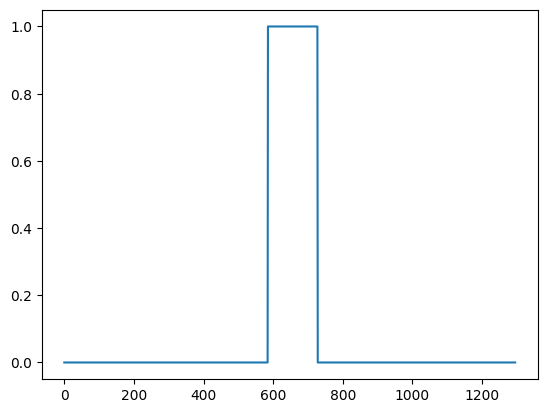

Chunk 1: 0 labels with value 1


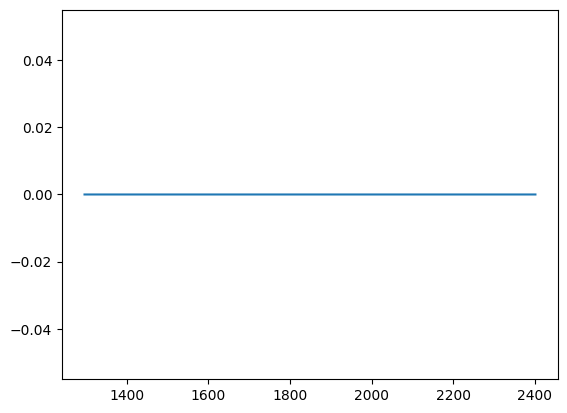

Chunk 2: 28 labels with value 1


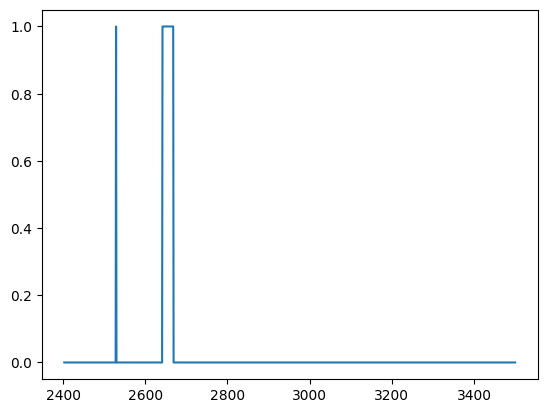

Chunk 3: 26 labels with value 1


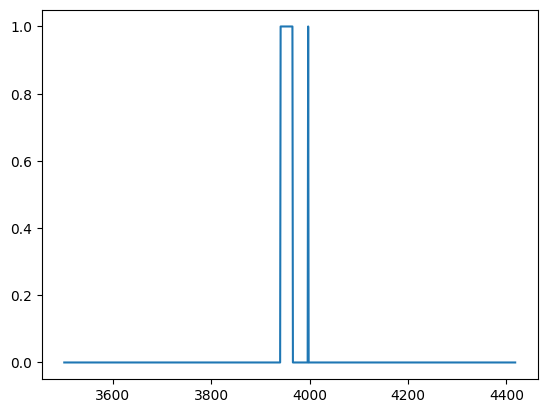

Chunk 4: 14 labels with value 1


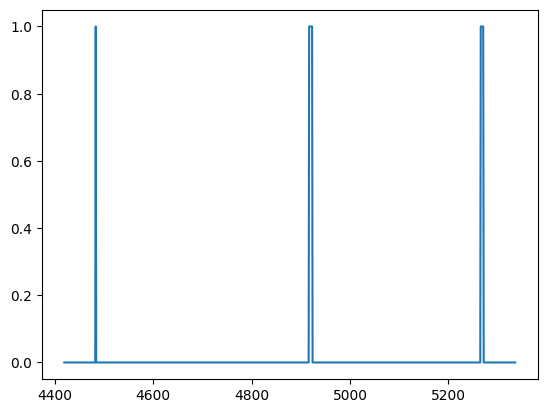

Chunk 5: 32 labels with value 1


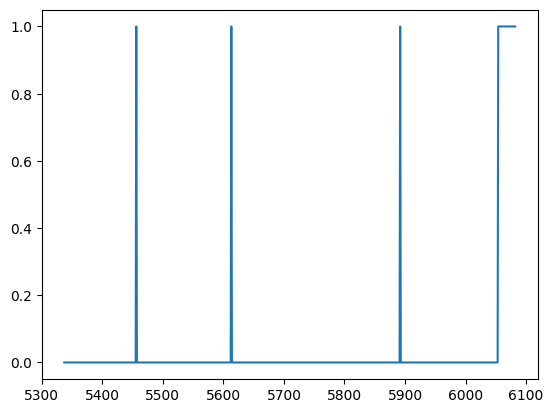

Chunk 6: 104 labels with value 1


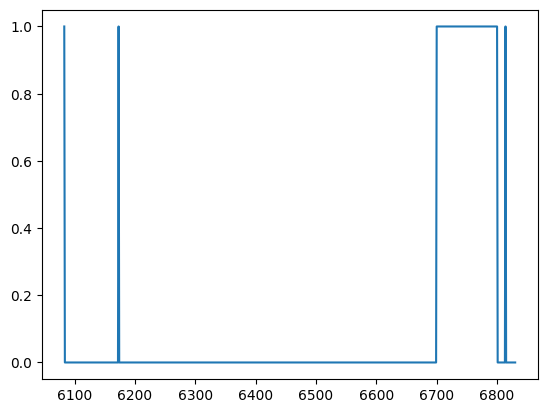

Chunk 7: 7 labels with value 1


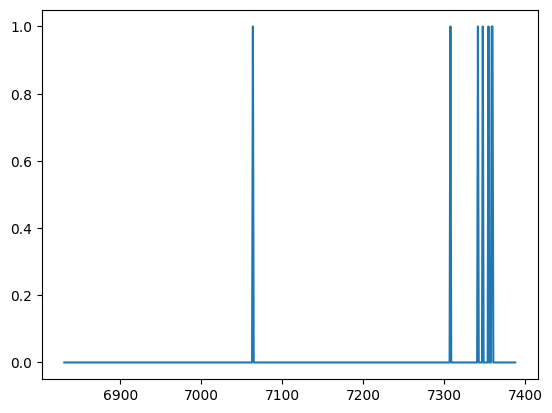

In [30]:
ranges = [(0, 1296), (1296, 2403), (2403, 3501), (3501, 4419), (4419, 5337), (5337, 6083), (6083, 6831), (6831, len(anomaly))]
plot_label_counts(submission, ranges)

In [15]:
train_data['label'] = train_cosine

In [9]:
x_train = train_data.drop('label', axis=1)
y_train = train_data['label']

In [ ]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(x_train, y_train)

y_pred = model.predict(test_data)

In [72]:
test_data['label'] = y_pred

In [75]:
test_data[test_data['label']>0.7]

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,pressure_flow_ratio,vibe_voltage_ratio,performance_index,pressure_load_ratio,vibe_rpm_ratio,vibe+rpm_temp,temp_diff,rpm*inflow,label
0,2.5100,53.2800,0.7000,32.5400,2662.0000,69.5800,3.4800,0.2789,0.1069,0.0008,0.6454,764.9425,38.3081,16.3000,3.4809,0.9999
1,2.6600,55.2400,0.7000,34.4500,2819.0000,71.3200,3.5700,0.2632,0.1036,0.0008,0.6096,789.6359,39.5761,16.0800,3.5709,0.9999
2,1.7200,42.7400,0.7000,22.2300,1819.0000,60.2100,3.0100,0.4070,0.1354,0.0009,0.9447,604.3189,30.2609,17.4700,3.0109,0.9998
3,2.2000,49.1500,0.7000,28.5000,2332.0000,65.9100,3.3000,0.3182,0.1158,0.0008,0.7368,706.6667,35.4316,16.7600,3.3009,0.9999
4,2.0600,47.2800,0.7000,26.6700,2182.0000,64.2400,3.2100,0.3398,0.1204,0.0008,0.7874,679.7508,34.0163,16.9600,3.2109,0.9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7384,2.1200,48.0800,0.7000,27.4500,2246.0000,64.9600,3.2500,0.3302,0.1184,0.0008,0.7650,691.0769,34.6252,16.8800,3.2509,0.9999
7385,1.4800,39.6300,0.7000,19.1900,1570.0000,57.4400,2.8700,0.4730,0.1496,0.0009,1.0943,547.0383,27.3828,17.8100,2.8709,0.9999
7386,1.5600,40.6100,0.7000,20.1500,1649.0000,58.3200,2.9200,0.4487,0.1449,0.0009,1.0422,564.7260,28.3251,17.7100,2.9209,0.9998
7387,1.5900,40.9900,0.7000,20.5200,1679.0000,58.6600,2.9300,0.4403,0.1428,0.0009,1.0234,573.0375,28.6725,17.6700,2.9309,0.9998


(array([1.000e+00, 0.000e+00, 2.000e+00, 5.000e+00, 0.000e+00, 6.000e+00,
        3.000e+01, 1.400e+01, 3.000e+00, 7.328e+03]),
 array([0.9966175 , 0.9969456 , 0.9972738 , 0.997602  , 0.9979301 ,
        0.99825823, 0.9985864 , 0.9989146 , 0.9992427 , 0.99957085,
        0.999899  ], dtype=float32),
 <BarContainer object of 10 artists>)

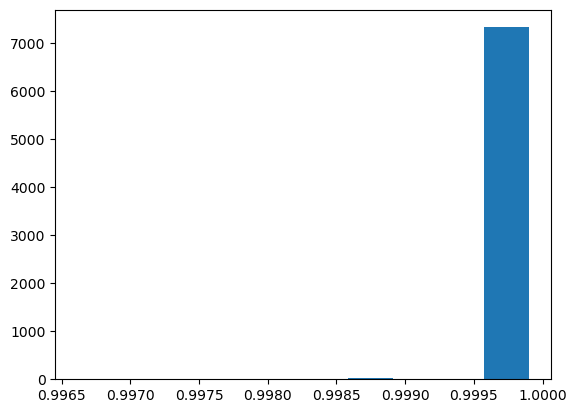

In [74]:
plt.hist(test_data.label)